In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import Dict, List, Tuple
import pickle
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

In [ ]:
FEATURE_COLS = [
    'Electrical speed [rad/s]',
    'I_M_a', 'I_M_b', 'I_M_c',
    'I_P_a', 'I_P_b', 'I_P_c',
    'I_B_a', 'I_B_b', 'I_B_c',
    'V_M_a', 'V_M_b', 'V_M_c',
    'V_P_a', 'V_P_b', 'V_P_c',
    'V_B_a', 'V_B_b', 'V_B_c'
]
LABEL_COL = 'Class label'

In [ ]:
uploaded = files.upload()
pkl_name = list(uploaded.keys())[0]

with open(pkl_name, 'rb') as f:
    saved = pickle.load(f)
if isinstance(saved, dict) and 'clf' in saved:
    #sv_transf
    clf = saved['clf']
    scaler = saved['scaler']
    all_classes = np.array(saved['classes'])
    MODEL_TYPE = 'sv_transfer'
    print(f"\nModèle chargé! (SV Transfer)")
    print(f"  Méthode: {saved.get('method', 'SV Transfer')}")
    print(f"  Classes connues: {list(all_classes)}")
    print(f"  Accuracy (train): {saved['accuracy_train']:.4f}")
    print(f"  Hyperparamètres: C={saved['C']:.4f}, gamma={saved['gamma']:.6f}")
    print(f"  Support Vectors: {saved['n_sv']}")
else:
    # Format LearnPPNC classique
    model = saved
    clf = None
    scaler = model.scaler
    all_classes = np.array(sorted(model.all_classes))
    MODEL_TYPE = 'learnpp'
    print(f"\nModèle chargé! (LearnPPNC)")
    print(f"  Nombre d'experts: {len(model.experts)}")
    print(f"  Classes connues: {list(all_classes)}")
    print(f"  Hyperparamètres: C={model.C:.4f}, gamma={model.gamma:.6f}")
    for i, e in enumerate(model.experts):
        print(f"  Expert #{i+1}: {e['name']} - Accuracy: {e['accuracy']:.4f} - SVs: {e['n_sv']}")

📁 CHARGER LE MODÈLE (.pkl):


Saving learnpp_sv_transfer.pkl to learnpp_sv_transfer.pkl

Modèle chargé! (SV Transfer)
  Méthode: SV Transfer (3 étapes)
  Classes connues: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]
  Accuracy (train): 0.9668
  Hyperparamètres: C=9970.9398, gamma=0.868983
  Support Vectors: 2504


In [ ]:
#try on new data
uploaded = files.upload()
test_file = list(uploaded.keys())[0]

df_test = pd.read_csv(test_file)
X_test = df_test[FEATURE_COLS].values
y_test = df_test[LABEL_COL].values

print(f"\nChargé: {len(y_test)} échantillons, {len(np.unique(y_test))} classes")
print(f"Classes: {sorted(np.unique(y_test))}")
print(f"\nDistribution:")
for c in sorted(np.unique(y_test)):
    print(f"  Classe {c:2d} : {np.sum(y_test == c):4d} échantillons")

test_classes = sorted(np.unique(y_test))
unknown = set(test_classes) - set(all_classes)
if unknown:
    print(f"\nunknow classes: {sorted(unknown)}")

📁 CHARGER LE NOUVEAU DATASET (.csv):


Saving data_exp9.csv to data_exp9.csv

Chargé: 5305 échantillons, 16 classes
Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]

Distribution:
  Classe  1 :   37 échantillons
  Classe  2 :  360 échantillons
  Classe  3 :  360 échantillons
  Classe  4 :  360 échantillons
  Classe  5 :  360 échantillons
  Classe  6 :  360 échantillons
  Classe  7 :  360 échantillons
  Classe  8 :  360 échantillons
  Classe  9 :  360 échantillons
  Classe 10 :  360 échantillons
  Classe 11 :  360 échantillons
  Classe 12 :  360 échantillons
  Classe 13 :  360 échantillons
  Classe 14 :  360 échantillons
  Classe 15 :  318 échantillons
  Classe 16 :  270 échantillons

✓ Toutes les classes du test sont connues du modèle


In [ ]:
X_test_sc = scaler.transform(X_test)

if MODEL_TYPE == 'sv_transfer':
    y_pred = clf.predict(X_test_sc)
    y_proba = clf.predict_proba(X_test_sc)
    confidence = np.max(y_proba, axis=1)
else:
    res = model.evaluate(X_test, y_test)
    y_pred = res['y_pred']
    confidence = res['confidence']

acc = accuracy_score(y_test, y_pred)

print("="*60)
print(f"  ACCURACY: {acc:.4f}")
print("="*60)
print(classification_report(y_test, y_pred, zero_division=0))

  ACCURACY: 0.9772

Classification Report:
              precision    recall  f1-score   support

           1       0.24      1.00      0.38        37
           2       1.00      1.00      1.00       360
           3       1.00      1.00      1.00       360
           4       1.00      1.00      1.00       360
           5       1.00      1.00      1.00       360
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       360
           8       1.00      1.00      1.00       360
           9       1.00      1.00      1.00       360
          10       1.00      1.00      1.00       360
          11       1.00      0.90      0.95       360
          12       1.00      0.90      0.95       360
          13       1.00      0.90      0.95       360
          14       0.99      0.99      0.99       360
          15       1.00      0.98      0.99       318
          16       1.00      0.99      1.00       270

    accuracy                         

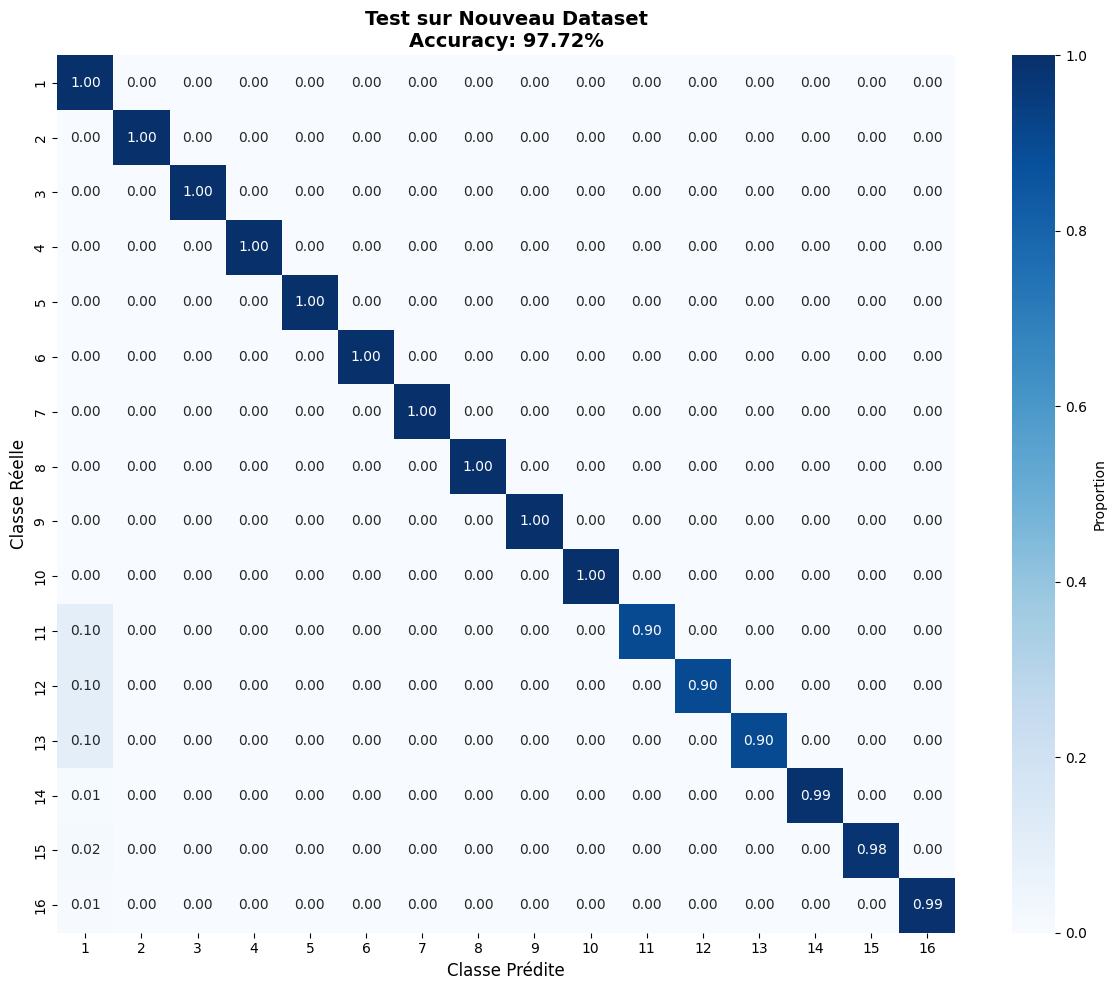

In [ ]:

fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred, labels=all_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=all_classes.astype(int),
            yticklabels=all_classes.astype(int),
            ax=ax, vmin=0, vmax=1,
            cbar_kws={'label': 'Proportion'})

ax.set_xlabel('Classe Prédite', fontsize=12)
ax.set_ylabel('Classe Réelle', fontsize=12)
ax.set_title(f"Test sur Nouveau Dataset\nAccuracy: {acc:.2%}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('test_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()